## CNN models rewritten with classes and re-ran with more data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torchvision.transforms as tf
import tarfile

from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

In [2]:
labels = open("spectrograms/labels.txt", "r")
classes = labels.read().split(',')
print(classes)

['English', ' French', ' Spanish', ' German']


In [3]:
# import our data set and convert to tensors
transformations = tf.Compose([tf.Resize([64,64]), tf.ToTensor()]) # our transformations when importing the images

dataset = ImageFolder('spectrograms', transform=transformations)

In [4]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 64, 64]) 0


tensor([[[0.0118, 0.0118, 0.0078,  ..., 0.0196, 0.2667, 0.5529],
         [0.1294, 0.1255, 0.1176,  ..., 0.1725, 0.4980, 0.7098],
         [0.2431, 0.2392, 0.2314,  ..., 0.3137, 0.6706, 0.8667],
         ...,
         [0.5098, 0.5294, 0.5765,  ..., 0.9569, 0.9608, 0.8196],
         [0.5686, 0.5255, 0.5490,  ..., 0.9765, 0.9490, 0.8157],
         [0.6000, 0.5922, 0.5765,  ..., 0.9765, 0.9373, 0.8392]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0745, 0.1608],
         [0.0549, 0.0549, 0.0510,  ..., 0.0627, 0.1451, 0.2157],
         [0.0627, 0.0627, 0.0627,  ..., 0.0824, 0.2078, 0.2941],
         ...,
         [0.1490, 0.1529, 0.1686,  ..., 0.4196, 0.4510, 0.2863],
         [0.1686, 0.1529, 0.1569,  ..., 0.4902, 0.4235, 0.2667],
         [0.1804, 0.1725, 0.1686,  ..., 0.4863, 0.3882, 0.2706]],

        [[0.0431, 0.0392, 0.0353,  ..., 0.0588, 0.3608, 0.4980],
         [0.2863, 0.2745, 0.2706,  ..., 0.3176, 0.4549, 0.4667],
         [0.4431, 0.4353, 0.4275,  ..., 0.4667, 0.4627, 0.

In [5]:
dataset.classes

['English', 'French', 'German', 'Spanish']

### check image files, delete this part after if necessary

In [6]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  English (0)


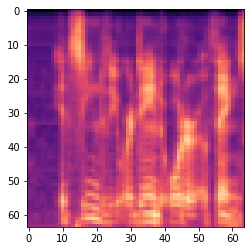

In [7]:
show_example(*dataset[0])

_______________________________________________________________________________

## Training, Validation Sets

In [8]:
random_seed = 10
torch.manual_seed(random_seed);

In [9]:
# train - validation split with validation being 20% of training data
val_size = int(len(dataset)*0.20)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(20800, 5200)

In [10]:
# set our batch size and intialize our data loader to feed batches into the model
batch_size=64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [11]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

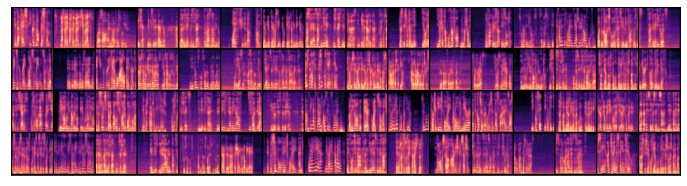

In [12]:
show_batch(train_dl)

## Models

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
## define some helper functions to evaluate (get accuracy or validate) and fit the model

def evaluate(model, dataloader, calc_loss=False):
    '''
    Helper function to get classification accuracy and (optional) loss for a model over the items in dataloader
    This function can just return the accuracy, or calculate the losses if "calc_loss" is set to "True"
    '''
    correct = 0
    total = 0
    losses = []
    
    # don't compute gradients
    with torch.no_grad():

        # iterate through all validation batches
        for batch in dataloader:
            inputs, labels = batch
            
            # forward pass through the model
            outputs = model(inputs)
            
            # calculate loss if parameter set to True
            if (calc_loss==True):            
                loss = CNN_model_1.loss(outputs, labels)   # Calculate loss
                losses.append(loss.detach)

            # Get the prediction of the net on the images
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            # Count those we got correct
            correct += (predicted == labels).sum().item()
        
        # calculate total correct cases
        acc = 100 * correct / total
    return losses, acc

def fit(epochs, model, train_loader, val_loader, lr, momentum, opt_func=torch.optim.SGD):
    ''' Function where we fit the model and record the metrics for each epoch with the inputted hyperparameters'''
    
    # Instantiate our model based on the parameters above
    CNN_model = model(opt_fun=opt_func, lr=lr, momentum=momentum)
    
    # train and validate for each epoch
    for epoch in range(epochs):
        # Training Phase 
        model.train()      # pytorch setting to sep train or eval
        train_losses = []
        val_losses = []
        
        for batch in train_loader:
            
            # calculate loss with forward pass
            inputs, labels = batch
            outputs = CNN_model(inputs)
            train_loss = CNN_model.loss(outputs, labels)
            
            # update weights and reset
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                       
            # tracks training loss and accuracy on the batch
            loss_sum += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            acc_sum += (labels == predicted).sum().item() / labels.shape[0]
        
        # Validation phase
        val_loss, val_acc = evaluate(CNN_model, val_loader, calc_loss=True) # run the validation function to get results
        val_loss_avg = np.mean(val_loss)
        
        # record training metrics
        train_loss_avg = loss_sum / len(train_dataloader)
        train_acc = acc_sum / len(train_dataloader)
                
        # print the metrics
        print(f"Epoch: {epoch+1} / {epochs+1} | "\
            f"Avg Train Loss: {np.round(train_loss_avg, 4)} | "\
            f"Train accuracy: {np.round(train_acc*100, 2)} | "\
            f"Avg Validation Loss: {np.round(val_loss_avg*100, 2)} | "\
            f"Validation Accuracy: {np.round(val_acc, 2)}")
        
    return train_loss, train_acc, val_loss, val_acc

#### First Model
let's try our first model

In [25]:
# First Simple Model
class CNN_model_1(nn.Module):
    def __init__(self, opt_fun=torch.optim.SGD, lr=0.005, momentum=1):
        super(CNN_model_1, self).__init__()

        self.forward = nn.Sequential(
            
            # convolution layers with max pooling 
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # our layer's input & output size, kernals, strides, padding 
            nn.ReLU(),                                             # activation function
            nn.MaxPool2d(2,2),                                     # max pooling: output 32x32x32

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),          
            nn.MaxPool2d(2,2),                                     # output 32x16x16

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),             
            nn.MaxPool2d(2,2),                                     # output 32x8x8

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),            
            nn.MaxPool2d(2,2),                                     # output 32x4x4

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),            
            nn.MaxPool2d(2,2),                                     # output 32x2x2

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),           
            nn.MaxPool2d(2,2),                                     # output 32x1x1
            
            # flatten and pass through a dense layer
            nn.Flatten(),                                          # flattens to a vector 
            nn.Linear(32, 4)                                       # output of 4 for each one of our classes
        )
        
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = opt_fun(self.parameters(), lr=lr, momentum=momentum)
    
    def forward(self, x):
        """Perform forward pass."""
        if (USE_GPU):
            x = x.cuda()
            
        # pass through the network
        return self.forward(x)

In [29]:
# fit the model

## Let's Try our Second (More Complex) Model
We have allowed the number of nodes per layer to expand, and we added more layers.

In [28]:
# Second slightly more complex model
class CNN_model_2(nn.Module):
    def __init__(self, opt_fun=torch.optim.SGD, lr=0.005, momentum=1):
        super(CNN_model_1, self).__init__()

        self.forward = nn.Sequential(
            
            # convolution layers
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 32 x 32
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 8 x 8
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 1024 x 4 x 4
            
            # flatten then go through some dense layers
            nn.Flatten(), 
            nn.Linear(512*4*4, 1024),  
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))   # output of 10 for each of our class
        
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = opt_fun(self.parameters(), lr=lr, momentum=momentum)
    
    def forward(self, x):
        """Perform forward pass."""
        if (USE_GPU):
            x = x.cuda()
            
        # pass through the network
        return self.forward(x)

## Let's try with dropout and batch normalization